In [1]:
import numpy as np
import pandas as pd
from collections import OrderedDict
import itertools
import statsmodels.formula.api as smf
import sys
import time
import requests
# Plotting packages
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns
import itertools
from statsmodels.tsa.arima.model import ARIMA
import os
import string
import warnings
import datetime
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import acf, pacf, graphics
from io import BytesIO
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
ct_emissions = pd.read_excel('../../../data/raw/Public GHG data 1990-2021.xlsx', sheet_name="Emission Totals")

# Extract the row corresponding to "Commercial"
row = ct_emissions[ct_emissions['Sector Emissions (MMTCO2e)'] == 'Waste (Wastewater)']

# Extract the columns from 1990 to 2021 estimate
columns_of_interest = [1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998,
                      1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
                      2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
                      2017, 2018, 2019, 2020, '2021 (ESTIMATE)']

data = row[columns_of_interest]

# Define new name for the last column
new_last_column_name = '2021'

# Rename the last column
data.rename(columns={data.columns[-1]: new_last_column_name}, inplace=True)

data

C:\Users\peiyaozhao\AppData\Local\Temp\ipykernel_17352\1372231312.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.rename(columns={data.columns[-1]: new_last_column_name}, inplace=True)


,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
21,0.359842,0.361827,0.362378,0.363307,0.365658,0.365747,0.367926,0.36852,0.371087,0.37503,...,0.393552,0.393541,0.394872,0.395203,0.394595,0.394567,0.394951,0.392797,0.391845,0.39


In [3]:
wastewater = pd.read_csv('../../../results/wastewater-emissions.csv')
wastewater

,Unnamed: 0,MSA,GHG Emissions (MMTCO2e),Ratio
0,0,New Haven-Milford,0.092857,0.238095
1,1,Hartford-East Hartford-Middletown,0.257877,0.583468
2,2,Bridgeport-Stamford-Norwalk,0.092147,0.196430


In [4]:
multipliers = wastewater['Ratio']
multiplied_df = pd.concat([data * multiplier for multiplier in multipliers], ignore_index=True)

In [5]:
multiplied_df 
data=multiplied_df.T

# Define new column names
new_column_names = ['New Haven (MMTCO2e)', 'Hartford (MMTCO2e)', 'Bridgeport (MMTCO2e)']

# Assign new column names to the DataFrame
data.columns = new_column_names

data.index.name = 'year'


data.index = pd.to_datetime(data.index, format='%Y')
data.index.freq = 'AS'
df=data
df

,New Haven (MMTCO2e),Hartford (MMTCO2e),Bridgeport (MMTCO2e)
year,,,
1990-01-01,0.085677,0.209956,0.070684
1991-01-01,0.086149,0.211115,0.071074
1992-01-01,0.086281,0.211436,0.071182
1993-01-01,0.086502,0.211978,0.071365
1994-01-01,0.087061,0.213350,0.071826
1995-01-01,0.087083,0.213402,0.071844
1996-01-01,0.087601,0.214673,0.072272
1997-01-01,0.087743,0.215020,0.072389
1998-01-01,0.088354,0.216517,0.072893


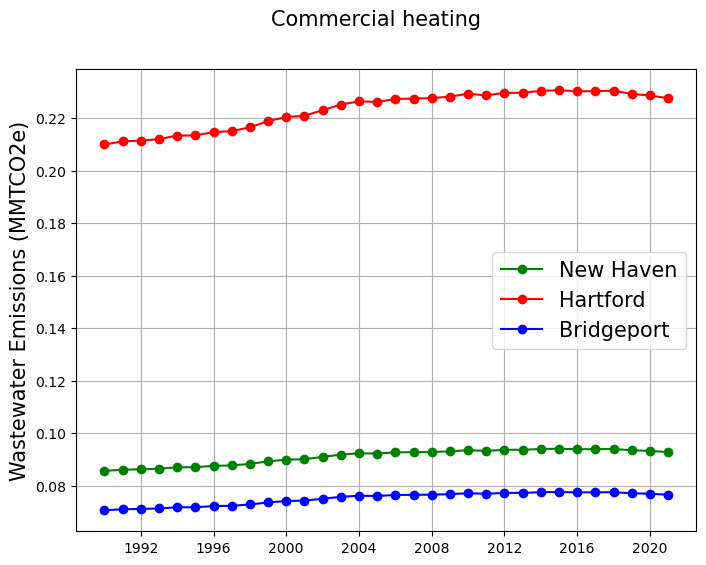

In [6]:
fig = plt.figure(figsize=(8,6))
fig.suptitle('Commercial heating',fontsize=15)
actual, = plt.plot(df.index, df['New Haven (MMTCO2e)'], 'go-', label='New Haven')
actual, = plt.plot(df.index, df['Hartford (MMTCO2e)'], 'ro-', label='Hartford')
actual, = plt.plot(df.index, df['Bridgeport (MMTCO2e)'], 'bo-', label='Bridgeport')
#plt.xlabel('Year',fontsize=18)
plt.ylabel('Wastewater Emissions (MMTCO2e)',fontsize=15)
#plt.xticks(np.arange(min(electr_residential.index), max(electr_residential.index)+1, 1)) 
plt.legend(fontsize=15)
plt.grid()
#plt.savefig('images/avetemp.png',bbox_inches='tight')
plt.savefig('../../../figures/wastewater-emissions-historical-change.png', dpi=600, bbox_inches='tight')

In [7]:
split_index = round(len(df)*0.8)
df_train = df.iloc[:split_index].copy()
df_test = df.iloc[split_index:].copy()

df_train.index.freq = 'AS'
df_test.index.freq = 'AS'

In [8]:
len(df_train)

26

In [9]:
len(df_test)

6

In [10]:
HEM_data = df['Hartford (MMTCO2e)']
NHM_data = df['New Haven (MMTCO2e)']
BSN_data = df['Bridgeport (MMTCO2e)']


warnings.filterwarnings("ignore")

def performance_metric(test, forecast):#observed and predicted
    """
    Evaluate forecast using different metrics.
    """
    mape = np.mean(np.abs((test - forecast) / test)) * 100
    mae = mean_absolute_error(test, forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))
    return mape, mae, rmse

def arima_prediction(train, test, order):
    # Fit the SARIMA model with the optimal parameters
    mod = sm.tsa.arima.ARIMA(train, order=order, enforce_stationarity=False, enforce_invertibility=False, concentrate_scale=False)
    res = mod.fit()
    
    # Generate predictions for the test set
    pred = res.get_prediction(start=len(train), end=len(train) + len(test) - 1)
    pred_mean = pred.predicted_mean
    
    # Evaluate forecast
    mape, mae, rmse = performance_metric(test, pred_mean)
    
    # Calculate BIC and AIC
    bic = res.bic
    #aic = res.aic
    
    return mape, mae, rmse, bic

def gridsearch(data): 

    # Initialize list to store results
    results_list_cv = []

    p_values = range(0,10)
    d_values = range(0,3)
    q_values = range(0,10)

    # Loop through each combination of p, d, q values
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                mape_cv = []
                mae_cv = []
                rmse_cv = []
                bic_cv = []
            

                split_index = round(len(data)*0.8)
                train = data.iloc[:split_index].copy()
                test = data.iloc[split_index:].copy()

                mape, mae, rmse, bic = arima_prediction(train, test, order)
                mape_cv.append(mape)
                mae_cv.append(mae)
                rmse_cv.append(rmse)
                bic_cv.append(bic)
                    #aic_cv.append(aic)
                    


                # Calculate the mean of metrics across folds
                mape_mean = np.mean(mape_cv)
                mae_mean = np.mean(mae_cv)
                rmse_mean = np.mean(rmse_cv)
                bic_mean = np.mean(bic_cv)
                #aic_mean = np.mean(aic_cv)

                # Store results
                results_list_cv.append({'p': p, 'd': d, 'q': q, 'MAPE': mape_mean, 'MAE': mae_mean, 'RMSE': rmse_mean, 'BIC':bic_mean})

    # Convert list of dictionaries to DataFrame
    results_df = pd.DataFrame(results_list_cv)
    return results_df

            
# Convert list of dictionaries to DataFrame
results_df_HEM_cv=gridsearch(HEM_data)
results_df_NHM_cv=gridsearch(NHM_data)
results_df_BSN_cv=gridsearch(BSN_data)

print(results_df_HEM_cv)

     p  d  q      MAPE       MAE      RMSE           BIC
0    0  0  0  3.095444  0.007105  0.007181   -172.178084
1    0  0  1  2.776932  0.006373  0.006457   -190.076205
2    0  0  2  2.336941  0.005361  0.005628   -200.743706
3    0  0  3  1.965652  0.004509  0.004707   -196.377115
4    0  0  4  2.156056  0.004949  0.005059   -151.834573
..  .. .. ..       ...       ...       ...           ...
295  9  2  5  3.602250  0.008273  0.009508  28506.857354
296  9  2  6  1.535684  0.003515  0.003964   -123.576807
297  9  2  7  1.219724  0.002790  0.003261   -118.879190
298  9  2  8  0.826596  0.001890  0.002322   -112.348748
299  9  2  9  0.826703  0.001890  0.002322   -100.423985

[300 rows x 7 columns]


In [11]:
test_HEM =results_df_HEM_cv.set_index(['p','d','q'])#.loc[:,'RMSE'].idxmin()
sorted_HEM=test_HEM.sort_values(by='RMSE').iloc[:10,:]
rounded_df = sorted_HEM.applymap(lambda x: f'{x:.3f}')
rounded_df

MAPE    MAE   RMSE       BIC
p d q                               
2 0 1  0.084  0.000  0.000  -257.509
0 1 6  0.295  0.001  0.001  -165.449
9 0 2  0.451  0.001  0.001  -157.711
    3  0.442  0.001  0.001  -155.166
    1  0.458  0.001  0.001  -156.709
2 0 2  0.465  0.001  0.001  -244.847
9 0 0  0.498  0.001  0.001  -174.291
0 1 3  0.452  0.001  0.001  -212.679
3 1 6  0.408  0.001  0.001  -152.009
0 2 6  0.539  0.001  0.002   816.822

In [12]:
test_NHM =results_df_NHM_cv.set_index(['p','d','q'])#.loc[:,'RMSE'].idxmin()
sorted_NHM=test_NHM.sort_values(by='RMSE').iloc[:10,:]
rounded_df = sorted_NHM.applymap(lambda x: f'{x:.3f}')
rounded_df

,,,MAPE,MAE,RMSE,BIC
p,d,q,,,,
2,0,1,0.133,0.000,0.000,-300.470
0,1,6,0.295,0.000,0.000,-197.716
8,0,0,0.292,0.000,0.000,-216.598
3,0,3,0.291,0.000,0.000,-263.362
4,0,1,0.296,0.000,0.000,-268.379
9,0,0,0.315,0.000,0.000,-204.358
4,0,0,0.301,0.000,0.000,-272.624
3,0,0,0.338,0.000,0.000,-286.571
2,0,3,0.313,0.000,0.000,-266.299


In [13]:
test_BSN =results_df_BSN_cv.set_index(['p','d','q'])#.loc[:,'RMSE'].idxmin()
sorted_BSN = test_BSN.sort_values(by='RMSE').iloc[:10,:]
rounded_df = sorted_BSN.applymap(lambda x: f'{x:.3f}')
rounded_df

,,,MAPE,MAE,RMSE,BIC
p,d,q,,,,
2,0,1,0.246,0.000,0.000,-309.652
0,1,6,0.295,0.000,0.000,-204.606
8,0,0,0.292,0.000,0.000,-223.524
4,0,1,0.296,0.000,0.000,-276.843
9,0,0,0.315,0.000,0.000,-210.914
4,0,0,0.299,0.000,0.000,-281.087
3,0,1,0.351,0.000,0.000,-290.799
9,0,3,0.376,0.000,0.000,-194.258
8,0,2,0.377,0.000,0.000,-217.221


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:     Hartford (MMTCO2e)   No. Observations:                   32
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 173.478
Date:                Wed, 08 May 2024   AIC                           -336.957
Time:                        13:00:37   BIC                           -329.951
Sample:                    01-01-1990   HQIC                          -334.715
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2100      0.023      9.047      0.000       0.165       0.256
ar.L1          2.0713      0.117     17.647      0.000       1.841       2.301
ar.L2         -1.0793      0.112     -9.661      0.000      -1.298      -0.860
ma.L1         -0.8274      0.199     -4.166      0.000      -1.217      -0.438
sigma2       5.31e-07   2.38e-07      2.228      0.026    6.39e-08    9.98e-07
===================================================================================
Ljung-Box (L1) (Q):                   1.21   Jarque-Bera (JB):                 1.10
Prob(Q):                              0.27   Prob(JB):                         0.58
Heteroskedasticity (H):               0.51   Skew:                            -0.37
Prob(H) (two-sided):                  0.30   Kurtosis:                         2.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

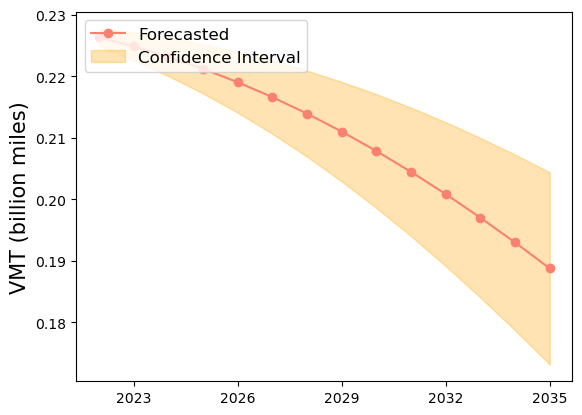

In [14]:
def arima_forecast(train, test, order,forecast_horizon,plot_file,color1,color2):
    # Fit the SARIMA model with the optimal parameters
    mod = sm.tsa.arima.ARIMA(train, order=order,enforce_stationarity= False, enforce_invertibility= False, concentrate_scale=False)
    #what are existing forecasting, few slides 
    res = mod.fit()

    forecast = res.forecast(steps=forecast_horizon)

    # Calculate the confidence interval
    forecast_object = res.get_forecast(steps=forecast_horizon)
    confidence_interval = forecast_object.conf_int()

    forecast.index = range(2022, 2022 + forecast_horizon)
    plt.plot(forecast.index, forecast, marker='o', color=color1, label='Forecasted')

    # Plot the confidence interval
    plt.fill_between(forecast.index, confidence_interval.iloc[:, 0], confidence_interval.iloc[:, 1], color=color2, alpha=0.3, label='Confidence Interval')

    plt.ylabel('VMT (billion miles)', fontsize=15)
    plt.legend(fontsize=12, loc='upper left')

    # Define the interval between x-ticks
    x_tick_interval = 3 # Change this value to set the desired interval

# Set x-ticks with the specified interval
    plt.xticks(range(2023, 2023 + forecast_horizon, x_tick_interval))

    # Save the plot
    plt.savefig(plot_file)

    return res,forecast,confidence_interval


HEM_train = df_train['Hartford (MMTCO2e)']
HEM_test = df_test['Hartford (MMTCO2e)']
HEM_data = df['Hartford (MMTCO2e)']
plot_file = '../../../figures/hartford-forecast-emissions-wastewater.png'  # File to save the plot

HEM_summary,HEM_forecast,HEM_confidence_interval=arima_forecast(HEM_data, HEM_test,(2,0,1),14, plot_file,'salmon','orange')
HEM_summary.summary()
#HEM_summary.pvalue

In [15]:
def arima_test_data_performance_metrics(train, test, order):
    # Fit the SARIMA model with the optimal parameters
    mod = sm.tsa.arima.ARIMA(train, order=order,enforce_stationarity= True, enforce_invertibility= False, concentrate_scale=False)
    #what are existing forecasting, few slides 
    res = mod.fit()

    test_forecast = res.get_prediction(start=len(train), end=len(train)+len(test)-1)
    test_forecast_mean = test_forecast.predicted_mean

    new_index = range(2023-len(test),2023)
    test_forecast_df = pd.DataFrame(list(test_forecast_mean.items()), columns=['Year', 'Emissions (MMTCO2e)'])
    test_forecast_df['Year'] = new_index


    # Set the 'Year' column as the index
    test_forecast_df.set_index('Year', inplace=True)
    
    test_forecast_df.index = pd.to_datetime(test_forecast_df.index, format='%Y')


    actual_values = test
    predicted_values = test_forecast_df['Emissions (MMTCO2e)']

    mae = mean_absolute_error(actual_values, predicted_values)
    rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
    mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100

    return mae, rmse, mape

HEM_train = df_train['Hartford (MMTCO2e)']
HEM_test = df_test['Hartford (MMTCO2e)']
mae, rmse, mape = arima_test_data_performance_metrics(HEM_train, HEM_test,(2,0,1))
print(mae)
print(rmse)
print(mape)

0.0009959666872362087
0.0013560772842981191
0.5155687335946723


<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                
===============================================================================
Dep. Variable:     New Haven (MMTCO2e)   No. Observations:                   32
Model:                  ARIMA(2, 0, 1)   Log Likelihood                 200.349
Date:                 Wed, 08 May 2024   AIC                           -390.698
Time:                         13:00:37   BIC                           -383.692
Sample:                     01-01-1990   HQIC                          -388.457
                          - 01-01-2021                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0858      0.009      9.552      0.000       0.068       0.103
ar.L1          2.0720      0.116     17.833      0.000       1.844       2.300
ar.L2         -1.0803      0.111     -9.771      0.000      -1.297      -0.864
ma.L1         -0.8278      0.195     -4.243      0.000      -1.210      -0.445
sigma2      8.744e-08    3.9e-08      2.240      0.025    1.09e-08    1.64e-07
===================================================================================
Ljung-Box (L1) (Q):                   1.20   Jarque-Bera (JB):                 1.13
Prob(Q):                              0.27   Prob(JB):                         0.57
Heteroskedasticity (H):               0.51   Skew:                            -0.38
Prob(H) (two-sided):                  0.30   Kurtosis:                         2.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

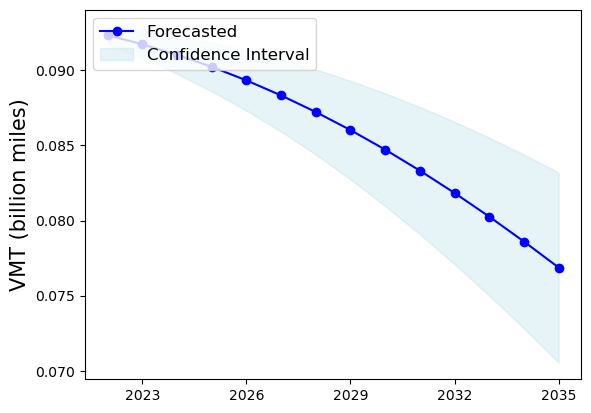

In [16]:
NHM_train = df_train['New Haven (MMTCO2e)']
NHM_test = df_test['New Haven (MMTCO2e)']
NHM_data = df['New Haven (MMTCO2e)']
plot_file = '../../../figures/newhaven-forecast-emissions-wastewater.png'  # File to save the plot

summary, NHM_forecast,NHM_confidence_interval=arima_forecast(NHM_data, NHM_test, (2,0,1),14, plot_file,'blue','lightblue')
summary.summary()

In [17]:
NHM_train = df_train['New Haven (MMTCO2e)']
NHM_test = df_test['New Haven (MMTCO2e)']
mae, rmse, mape = arima_test_data_performance_metrics(NHM_train, NHM_test,(2,0,1))
print(mae, rmse, mape)

0.00026159863283894275 0.0003239395627002443 0.17841034299843633


<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:     Bridgeport (MMTCO2e)   No. Observations:                   32
Model:                   ARIMA(2, 0, 1)   Log Likelihood                 206.124
Date:                  Wed, 08 May 2024   AIC                           -402.248
Time:                          13:00:37   BIC                           -395.242
Sample:                      01-01-1990   HQIC                          -400.006
                           - 01-01-2021                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0706      0.008      8.894      0.000       0.055       0.086
ar.L1          2.0720      0.116     17.821      0.000       1.844       2.300
ar.L2         -1.0799      0.111     -9.759      0.000      -1.297      -0.863
ma.L1         -0.8280      0.196     -4.227      0.000      -1.212      -0.444
sigma2      5.933e-08   2.64e-08      2.247      0.025    7.58e-09    1.11e-07
===================================================================================
Ljung-Box (L1) (Q):                   1.20   Jarque-Bera (JB):                 1.09
Prob(Q):                              0.27   Prob(JB):                         0.58
Heteroskedasticity (H):               0.50   Skew:                            -0.37
Prob(H) (two-sided):                  0.30   Kurtosis:                         2.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

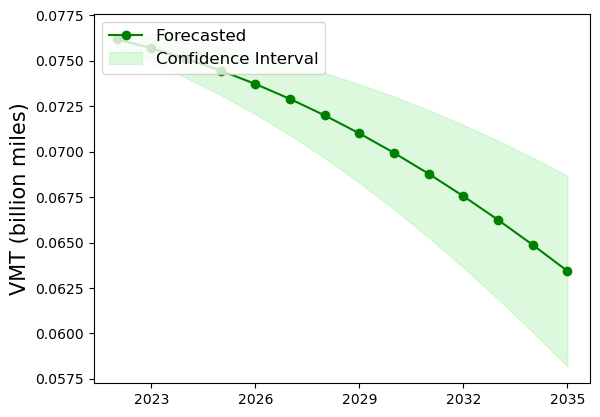

In [18]:
BSN_train = df_train['Bridgeport (MMTCO2e)']
BSN_test = df_test['Bridgeport (MMTCO2e)']
BSN_data = df['Bridgeport (MMTCO2e)']
plot_file = '../../../figures/bridgeport-forecast-emissions-wastewater.png'  # File to save the plot

summary, BSN_forecast,BSN_confidence_interval=arima_forecast(BSN_data, BSN_test,(2,0,1),14, plot_file,'green','lightgreen')#chagne the function name. make function shorter; call old function in new function
summary.summary()
#summary.pvalues

In [19]:
mae, rmse, mape = arima_test_data_performance_metrics(BSN_train, BSN_test,(2,0,1))
print(mae,rmse, mape)

0.00027476201750498835 0.00031743914293687266 0.20882625002319735


In [20]:
def test_train_fitting_VMT(train,order):
    # Forecast on training data
    mod = sm.tsa.arima.ARIMA(train, order=order)
    res = mod.fit()
    
    train_forecast = res.get_prediction(start=0, end=len(train)-1)
    train_forecast_mean = train_forecast.predicted_mean.iloc[1:]
    train_conf_int = train_forecast.conf_int().iloc[1:]

    #test_forecast = res.get_prediction(start=len(train), end=len(train)+len(test)-1)
    #test_forecast_mean = test_forecast.predicted_mean
    #test_conf_int = test_forecast.conf_int()
    
    return train_forecast_mean,train_conf_int
    

emissions_train_HEM,train_conf_int_HEM=test_train_fitting_VMT(HEM_data,(2,0,1))
emissions_train_NHM,train_conf_int_NHM=test_train_fitting_VMT(NHM_data,(2,0,1))
emissions_train_BSN,train_conf_int_BSN=test_train_fitting_VMT(BSN_data,(2,0,1))
    

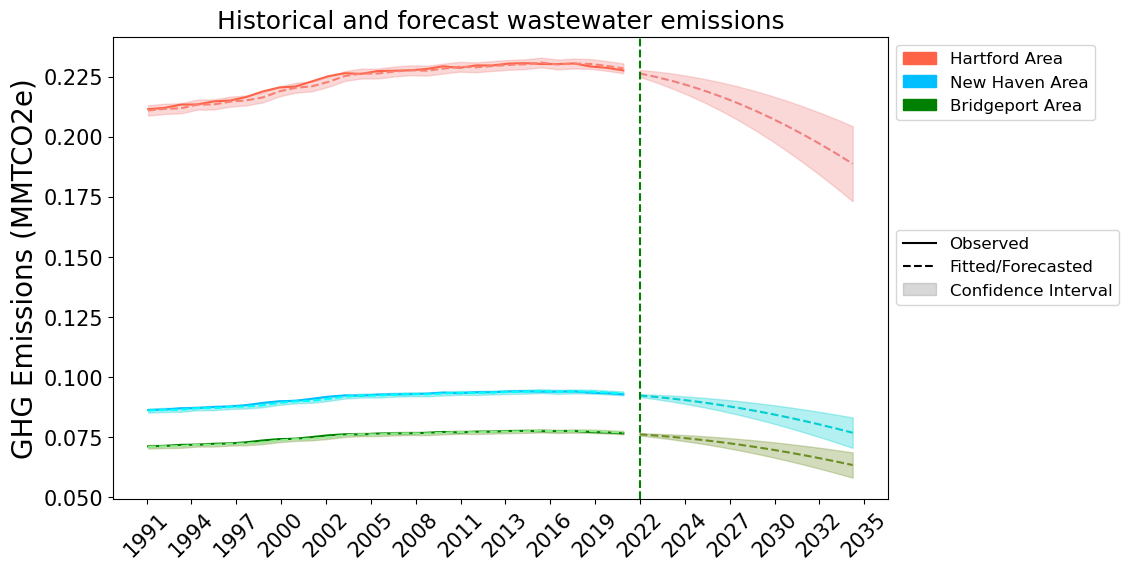

In [21]:
plt.figure(figsize=(10, 6))


concatenated_observed_HEM = pd.concat([HEM_train,HEM_test])[2:]
concatenated_predicted_HEM = emissions_train_HEM[1:]
HEM_forecast.index = pd.to_datetime(HEM_forecast.index, format='%Y')
plt.plot(concatenated_observed_HEM.index, concatenated_observed_HEM,label='Hartford_Observed', color='tomato')
plt.plot(concatenated_predicted_HEM.index, concatenated_predicted_HEM, label='Hartford_Fitted', color='salmon', linestyle='--')

plt.plot(HEM_forecast.index, HEM_forecast, color='lightcoral', label='Hartford_Forecasted',linestyle='--')
plt.fill_between(HEM_forecast.index, HEM_confidence_interval.iloc[:, 0], HEM_confidence_interval.iloc[:, 1], color='lightcoral', alpha=0.3)
plt.fill_between(emissions_train_HEM[1:].index, train_conf_int_HEM.iloc[1:, 0], train_conf_int_HEM.iloc[1:, 1], color='lightcoral', alpha=0.3)


concatenated_observed_NHM = pd.concat([NHM_train,NHM_test])[2:]
concatenated_predicted_NHM = emissions_train_NHM[1:]
NHM_forecast.index = pd.to_datetime(NHM_forecast.index, format='%Y')
plt.plot(concatenated_observed_NHM.index, concatenated_observed_NHM,label='New Haven_Observed', color='deepskyblue')
plt.plot(concatenated_predicted_NHM.index, concatenated_predicted_NHM, label='New Haven_Fitted', color='cyan', linestyle='--')

plt.plot(NHM_forecast.index, NHM_forecast, color='darkturquoise', label='New Haven_Forecasted',linestyle='--')
plt.fill_between(NHM_forecast.index, NHM_confidence_interval.iloc[:, 0], NHM_confidence_interval.iloc[:, 1], color='darkturquoise', alpha=0.3)
plt.fill_between(emissions_train_NHM[1:].index, train_conf_int_NHM.iloc[1:, 0], train_conf_int_NHM.iloc[1:, 1], color='darkturquoise', alpha=0.3)

concatenated_observed_BSN = pd.concat([BSN_train,BSN_test])[2:]
concatenated_predicted_BSN = emissions_train_BSN[1:]
BSN_forecast.index = pd.to_datetime(BSN_forecast.index, format='%Y')
plt.plot(concatenated_observed_BSN.index, concatenated_observed_BSN,label='Bridgeport_Observed', color='green')
plt.plot(concatenated_predicted_BSN.index, concatenated_predicted_BSN, label='Bridgeport_Fitted', color='lightgreen', linestyle='--')

plt.plot(BSN_forecast.index, BSN_forecast, color='olivedrab', label='Bridgeport_Forecasted',linestyle='--')
plt.fill_between(BSN_forecast.index, BSN_confidence_interval.iloc[:, 0], BSN_confidence_interval.iloc[:, 1], color='olivedrab', alpha=0.3)
plt.fill_between(emissions_train_BSN[1:].index, train_conf_int_BSN.iloc[1:, 0], train_conf_int_BSN.iloc[1:, 1], color='olivedrab', alpha=0.3)


# Legend for Colors (Locations)
tomato_patch = mpatches.Patch(color='tomato', label='Hartford Area')
deepskyblue_patch = mpatches.Patch(color='deepskyblue', label='New Haven Area')
green_patch = mpatches.Patch(color='green', label='Bridgeport Area')
color_legend = plt.legend(handles=[tomato_patch, deepskyblue_patch, green_patch], title="", fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))

# Add the first legend manually to the plot
plt.gca().add_artist(color_legend)

# Legend for Patterns (Data Types)
solid_line = mlines.Line2D([], [], color='black', label='Observed')
dashed_line = mlines.Line2D([], [], color='black', linestyle='--', label='Fitted/Forecasted')
alpha_patch = mpatches.Patch(color='grey', alpha=0.3, label='Confidence Interval')
plt.legend(handles=[solid_line, dashed_line, alpha_patch], title="", fontsize=12, loc='upper left', bbox_to_anchor=(1, 0.6))

# Title, labels, ticks, and other plot formatting as per your code
plt.title('Historical and forecast wastewater emissions', fontsize=18)
plt.ylabel('GHG Emissions (MMTCO2e)', fontsize=20)

plt.xticks(fontsize=15, rotation=45) 
plt.yticks(fontsize=15)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(prune='both', nbins=20))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Add a vertical line at the x-axis for the year 2016
plt.axvline(x=datetime.datetime(2022, 1, 1), color='green', linestyle='--', label='Year 2022 (X-axis)')


plt.savefig('../../../figures/wastewater_forecast.png', dpi=600, bbox_inches='tight')

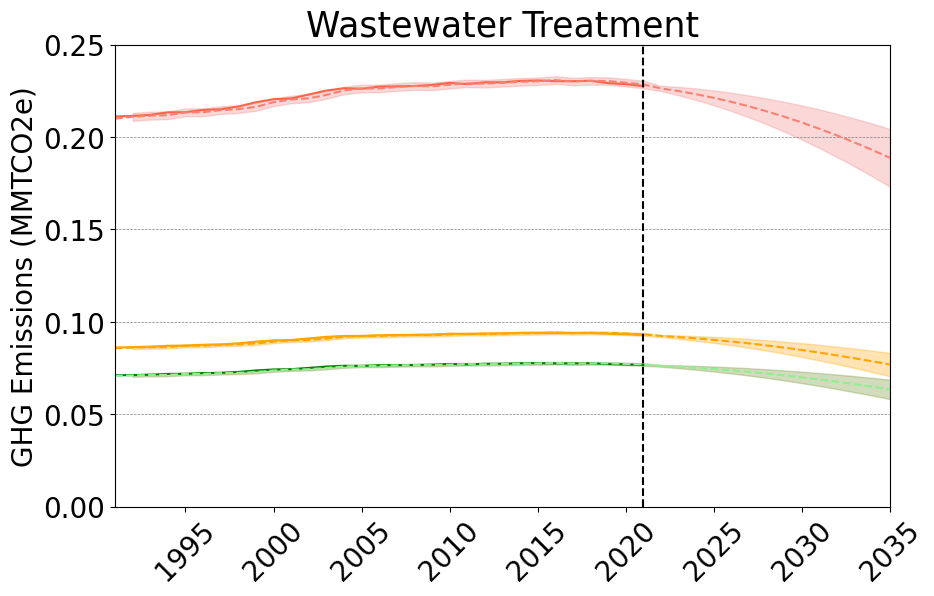

In [36]:
plt.figure(figsize=(10, 6))


concatenated_observed_HEM = pd.concat([HEM_train,HEM_test])[1:]
HEM_forecast.index = pd.to_datetime(HEM_forecast.index, format='%Y')
concatenated_predicted_forecast_HEM = pd.concat([emissions_train_HEM,HEM_forecast])

plt.plot(concatenated_observed_HEM.index, concatenated_observed_HEM,label='Hartford_Observed', color='tomato')
plt.plot(concatenated_predicted_forecast_HEM.index, concatenated_predicted_forecast_HEM, label='Hartford_Fitted', color='salmon', linestyle='--')

concatenated_confidence_interval_HEM = pd.concat([train_conf_int_HEM, HEM_confidence_interval])
plt.fill_between(concatenated_confidence_interval_HEM[1:].index, concatenated_confidence_interval_HEM.iloc[1:, 0], concatenated_confidence_interval_HEM.iloc[1:, 1], color='lightcoral', alpha=0.3)



concatenated_observed_NHM = pd.concat([NHM_train,NHM_test])[1:]
NHM_forecast.index = pd.to_datetime(NHM_forecast.index, format='%Y')
concatenated_predicted_forecast_NHM = pd.concat([emissions_train_NHM,NHM_forecast])

plt.plot(concatenated_observed_NHM.index, concatenated_observed_NHM,label='New Haven_Observed', color='orange')
plt.plot(concatenated_predicted_forecast_NHM.index, concatenated_predicted_forecast_NHM, label='New Haven_Fitted', color='orange', linestyle='--')

concatenated_confidence_interval_NHM = pd.concat([train_conf_int_NHM, NHM_confidence_interval])
plt.fill_between(concatenated_confidence_interval_NHM[1:].index, concatenated_confidence_interval_NHM.iloc[1:, 0], concatenated_confidence_interval_NHM.iloc[1:, 1], color='orange', alpha=0.3)


concatenated_observed_BSN = pd.concat([BSN_train,BSN_test])[1:]
BSN_forecast.index = pd.to_datetime(BSN_forecast.index, format='%Y')
concatenated_predicted_forecast_BSN = pd.concat([emissions_train_BSN,BSN_forecast])

plt.plot(concatenated_observed_BSN.index, concatenated_observed_BSN,label='Bridgeport_Observed', color='green')
plt.plot(concatenated_predicted_forecast_BSN.index, concatenated_predicted_forecast_BSN, label='Bridgeport_Fitted', color='lightgreen', linestyle='--')

concatenated_confidence_interval_BSN = pd.concat([train_conf_int_BSN, BSN_confidence_interval])
plt.fill_between(concatenated_confidence_interval_BSN[1:].index, concatenated_confidence_interval_BSN.iloc[1:, 0], concatenated_confidence_interval_BSN.iloc[1:, 1], color='olivedrab', alpha=0.3)


# # Legend for Colors (Locations)
# tomato_patch = mpatches.Patch(color='tomato', label='Hartford Area')
# deepskyblue_patch = mpatches.Patch(color='orange', label='New Haven Area')
# green_patch = mpatches.Patch(color='green', label='Bridgeport Area')
# color_legend = plt.legend(handles=[tomato_patch, deepskyblue_patch, green_patch], title="", fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))

# # Add the first legend manually to the plot
# plt.gca().add_artist(color_legend)

# # Legend for Patterns (Data Types)
# solid_line = mlines.Line2D([], [], color='black', label='Observed')
# dashed_line = mlines.Line2D([], [], color='black', linestyle='--', label='Fitted/Forecasted')
# alpha_patch = mpatches.Patch(color='grey', alpha=0.3, label='Confidence Interval')
# plt.legend(handles=[solid_line, dashed_line, alpha_patch], title="", fontsize=12, loc='upper left', bbox_to_anchor=(1, 0.6))

# Title, labels, ticks, and other plot formatting as per your code
plt.title('Wastewater Treatment', fontsize=25)
plt.ylabel('GHG Emissions (MMTCO2e)', fontsize=20)

plt.xticks(fontsize=20, rotation=45) 
plt.yticks(fontsize=20)
# plt.gca().xaxis.set_major_locator(plt.MaxNLocator(prune='both', nbins=20))
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Add a vertical line at the x-axis for the year 2016
plt.axvline(x=datetime.datetime(2021, 1, 1), color='black', linestyle='--', label='Year 2022 (X-axis)')

# Hide the grid lines behind the line plot
plt.grid(axis='y', linestyle='--', color='gray', linewidth=0.5, zorder=1)

plt.xlim(datetime.datetime(1991, 1, 1), datetime.datetime(2035, 1, 1))

max_y_value = 0.3
plt.yticks(np.arange(0, max_y_value, 0.05))


plt.savefig('../../../figures/wastewater_forecast.png', dpi=600, bbox_inches='tight')

In [23]:
HEM_2022 = concatenated_observed_HEM[-1]
HEM_2035 = concatenated_predicted_forecast_HEM[-1]
HEM_per = (HEM_2022-HEM_2035)/HEM_2022*100 #%

In [24]:
NHM_2022 = concatenated_observed_NHM[-1]
NHM_2035 = concatenated_predicted_forecast_NHM[-1]
NHM_per = (NHM_2022-NHM_2035)/NHM_2022*100 #%

In [25]:
BSN_2022 = concatenated_observed_BSN[-1]
BSN_2035 = concatenated_predicted_forecast_BSN[-1]
BSN_per = (BSN_2022-BSN_2035)/BSN_2022*100 #% 

In [26]:
print(HEM_per,NHM_per,BSN_per)

17.05427733624029 17.21136989500628 17.202059527302115


In [27]:
concatenated_predicted_forecast_HEM.index = pd.to_datetime(concatenated_predicted_forecast_HEM.index)
concatenated_observed_HEM.index = pd.to_datetime(concatenated_observed_HEM.index)

# Extract data for the year 2021
HEM_2021 = concatenated_observed_HEM['2021'].values
HEM_2035 = concatenated_predicted_forecast_HEM['2035'].values


concatenated_predicted_forecast_NHM.index = pd.to_datetime(concatenated_predicted_forecast_NHM.index)
concatenated_observed_NHM.index = pd.to_datetime(concatenated_observed_NHM.index)

NHM_2021 = concatenated_observed_NHM['2021'].values
NHM_2035= concatenated_predicted_forecast_NHM['2034'].values


concatenated_predicted_forecast_BSN.index = pd.to_datetime(concatenated_predicted_forecast_BSN.index)
concatenated_observed_BSN.index = pd.to_datetime(concatenated_observed_BSN.index)

# Extract data for the year 2021
BSN_2021 = concatenated_observed_BSN['2021'].values
BSN_2035= concatenated_predicted_forecast_BSN['2034'].values


#how to calculate the difference: the difference equals the (old-new)/old
NHM_per = (NHM_2021-NHM_2035)/NHM_2021*100 #%

HEM_per = (HEM_2021-HEM_2035)/HEM_2021*100 #%

BSN_per = (BSN_2021-BSN_2035)/BSN_2021*100 #%

print(HEM_per,NHM_per,BSN_per)

[17.05427734] [15.34815352] [15.32301807]


In [28]:
df = pd.DataFrame({'Column1': -HEM_per, 'Column2': -NHM_per, 'Column3': -BSN_per})
df

,Column1,Column2,Column3
0,-17.054277,-15.348154,-15.323018


In [29]:
data = pd.DataFrame({'Column1': HEM_2021, 'Column2': HEM_2035, 'Column3': NHM_2021, 'Column4': NHM_2035, 'Column5': BSN_2021, 'Column6': BSN_2035})
data

,Column1,Column2,Column3,Column4,Column5,Column6
0,0.227553,0.188745,0.092857,0.078605,0.076608,0.064869


In [30]:
concatenated_predicted_forecast_NHM

1991-01-01    0.085677
1992-01-01    0.086074
1993-01-01    0.086328
1994-01-01    0.086435
1995-01-01    0.087061
1996-01-01    0.087082
1997-01-01    0.087555
1998-01-01    0.087774
1999-01-01    0.088278
2000-01-01    0.089293
2001-01-01    0.089915
2002-01-01    0.090159
2003-01-01    0.090916
2004-01-01    0.091902
2005-01-01    0.092329
2006-01-01    0.092331
2007-01-01    0.092667
2008-01-01    0.092880
2009-01-01    0.092811
2010-01-01    0.093163
2011-01-01    0.093482
2012-01-01    0.093384
2013-01-01    0.093601
2014-01-01    0.093797
2015-01-01    0.093911
2016-01-01    0.094193
2017-01-01    0.093867
2018-01-01    0.094025
2019-01-01    0.093956
2020-01-01    0.093624
2021-01-01    0.093213
2022-01-01    0.092347
2023-01-01    0.091742
2024-01-01    0.091040
2025-01-01    0.090239
2026-01-01    0.089337
2027-01-01    0.088334
2028-01-01    0.087230
2029-01-01    0.086026
2030-01-01    0.084724
2031-01-01    0.083327
2032-01-01    0.081838
2033-01-01    0.080262
2034-01-01 

In [31]:
concatenated_confidence_interval_HEM['ME'] = (concatenated_confidence_interval_HEM.iloc[:, 1] - concatenated_confidence_interval_HEM.iloc[:, 0]) / 2
concatenated_confidence_interval_HEM

,lower Hartford (MMTCO2e),upper Hartford (MMTCO2e),ME
1991-01-01,0.207776,0.212137,0.002181
1992-01-01,0.208767,0.213062,0.002148
1993-01-01,0.209434,0.213683,0.002125
1994-01-01,0.209696,0.213911,0.002108
1995-01-01,0.211251,0.215441,0.002095
1996-01-01,0.211316,0.215485,0.002085
1997-01-01,0.212477,0.216630,0.002076
1998-01-01,0.213028,0.217168,0.002070
1999-01-01,0.214258,0.218387,0.002064
2000-01-01,0.216757,0.220877,0.002060


In [32]:
concatenated_confidence_interval_NHM['ME'] = (concatenated_confidence_interval_NHM.iloc[:, 1] - concatenated_confidence_interval_NHM.iloc[:, 0]) / 2
concatenated_confidence_interval_NHM

,lower New Haven (MMTCO2e),upper New Haven (MMTCO2e),ME
1991-01-01,0.084802,0.086553,0.000875
1992-01-01,0.085210,0.086938,0.000864
1993-01-01,0.085472,0.087184,0.000856
1994-01-01,0.085585,0.087285,0.000850
1995-01-01,0.086215,0.087906,0.000845
1996-01-01,0.086241,0.087924,0.000841
1997-01-01,0.086717,0.088393,0.000838
1998-01-01,0.086938,0.088610,0.000836
1999-01-01,0.087444,0.089112,0.000834
2000-01-01,0.088461,0.090125,0.000832


In [33]:
concatenated_confidence_interval_BSN['ME'] = (concatenated_confidence_interval_BSN.iloc[:, 1] - concatenated_confidence_interval_BSN.iloc[:, 0]) / 2
concatenated_confidence_interval_BSN

,lower Bridgeport (MMTCO2e),upper Bridgeport (MMTCO2e),ME
1991-01-01,0.069940,0.071427,0.000744
1992-01-01,0.070275,0.071741,0.000733
1993-01-01,0.070496,0.071947,0.000726
1994-01-01,0.070587,0.072027,0.000720
1995-01-01,0.071109,0.072540,0.000716
1996-01-01,0.071130,0.072555,0.000713
1997-01-01,0.071522,0.072941,0.000710
1998-01-01,0.071706,0.073122,0.000708
1999-01-01,0.072122,0.073534,0.000706
2000-01-01,0.072962,0.074371,0.000704
